In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators import solve_poisson_equation, psi_ln_sw, solve_poisson_equation_two_stream, fft_, density_convolve

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# Ion Acoustic

In [4]:
# set up configuration parameters
# number of mesh points in x
Nx = 20
# number of spectral expansions
Nv = 10
# epsilon displacement in initial electron distribution
epsilon = 1e-3
# velocity scaling of electron and ion
alpha_e = np.sqrt(2)
alpha_i = np.sqrt(2 / 50)
# x grid is from 0 to L
L = 10 * np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L / (Nx - 1)
# time stepping
dt = 1e-3
# final time (non-dimensional)
T = 10.
t_vec = np.linspace(0, T, int(T / dt) + 1)
# velocity scaling
u_e = 2
u_i = 0
# mass normalized
m_e = 1
m_i = 25
# charge normalized
q_e = -1
q_i = 1

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-5, 5, int(1e5))
# spatial grid 
x_project = np.linspace(0, L, 10000)
x = np.linspace(0, L, 2*Nx+1)

In [6]:
# initial condition of the first expansion coefficient
C_0e = np.zeros(2 * Nx + 1)
C_0i = np.zeros(2 * Nx + 1)

C_0i[Nx] = np.sqrt(1 / alpha_i)

In [7]:
C_0e = np.sqrt((1 + epsilon*np.cos(x))/alpha_e)
C_0e_coeff = np.zeros((2*Nx+1), dtype="complex128")

In [8]:
for ii, kk in enumerate(range(-Nx, Nx+1)):
    C_0e_coeff[ii] = np.trapz(y=np.sqrt((1 + epsilon * np.cos(1 / 5 * x_project)) / alpha_e) * np.exp(-2 * np.pi * 1j * kk * x_project / L), x=x_project,
                            dx=x_project[1] - x_project[0]) / L

In [9]:
# initialize states (electrons and ions)
states_e = np.zeros((Nv, Nx * 2 + 1), dtype="complex128")
states_i = np.zeros((Nv, Nx * 2 + 1), dtype="complex128")

# initialize the expansion coefficients
states_e[0, :] = C_0e_coeff
states_i[0, :] = C_0i

In [10]:
E_coeff = solve_poisson_equation(state_e=states_e,
                                  state_i=states_i,
                                  alpha_e=alpha_e,
                                  alpha_i=alpha_i,
                                  Nx=Nx,
                                  L=L, u_e=u_e, u_i=u_i)

mean current error =  4.440892098500626e-16
charge neutrality =  1.7447452129375698e-16


In [11]:
# fft of electric field 
E_field= fft_(coeff=E_coeff, Nx=Nx, x=x, L=L)

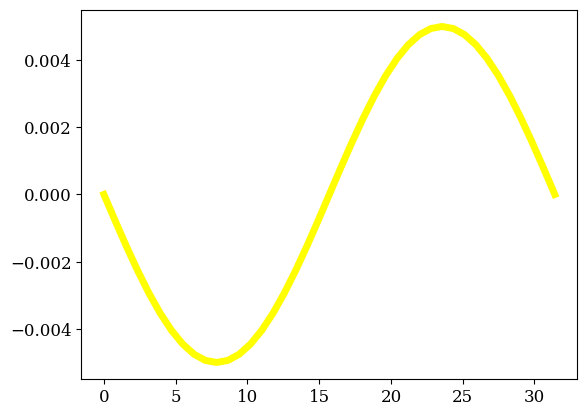

In [12]:
plt.plot(x, E_field, linewidth=5, color="yellow", label="E")

In [13]:
# the distribution function of electrons and protons for plotting purposes
f_0e = np.outer(fft_(C_0e_coeff, Nx, x, L), psi_ln_sw((v-u_e)/alpha_e, n=0)).real
f_0i = np.outer(fft_(C_0i, Nx, x, L), psi_ln_sw((v-u_i)/alpha_i, n=0)).real

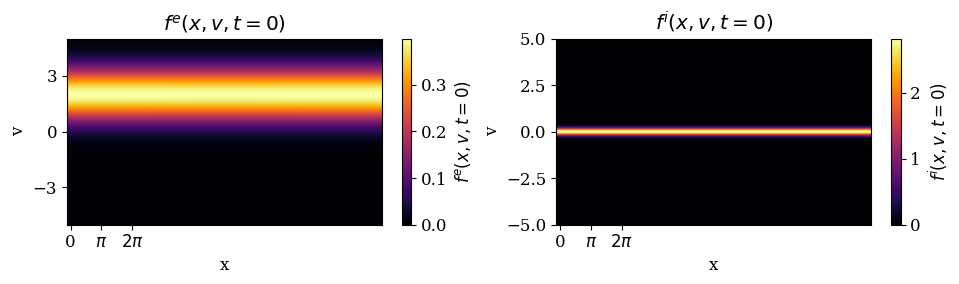

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, (f_0e**2).T, cmap="inferno")
ax[0].set_xlabel("x")
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)

cbar.ax.set_ylabel('$f^{e}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, (f_0i**2).T, cmap="inferno")
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_ylabel("v")
ax[1].set_xlabel("x")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{i}(x, v, t=0)$")
plt.tight_layout()
plt.savefig("figs/SW_sqrt/ion_acoustic/poisson/initial_condition.png", dpi=600)

In [15]:
sol_midpoint_u = np.load("data/SW_sqrt/ion_acoustic/poisson/sol_midpoint_u_101.npy")
sol_midpoint_t = np.load("data/SW_sqrt/ion_acoustic/poisson/sol_midpoint_t_101.npy")
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(820, 10001)
(10001,)


In [16]:
# initialize the electric potential
E_midpoint = np.zeros((2*Nx+1, len(sol_midpoint_t)), dtype="complex128")

In [17]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((Nv, 2*Nx+1, len(sol_midpoint_t)), dtype="complex128")
state_i_midpoint = np.zeros((Nv, 2*Nx+1, len(sol_midpoint_t)), dtype="complex128")


for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the linear system
        state_e_midpoint[jj, :, ii] = sol_midpoint_u[jj * (2 * Nx + 1): (jj + 1) * (2 * Nx + 1), ii]
        state_i_midpoint[jj, :, ii] = sol_midpoint_u[Nv * (2 * Nx + 1) + jj * (2 * Nx + 1): Nv * (2 * Nx + 1) + (jj + 1) * (2 * Nx + 1), ii]
        
    E_midpoint[:, ii] = solve_poisson_equation(state_e=state_e_midpoint[:, :, ii],
                                          state_i=state_i_midpoint[:, :, ii],
                                          alpha_e=alpha_e,
                                          alpha_i=alpha_i,
                                          Nx=Nx,
                                          L=L, u_e=u_e, u_i=u_i)

mean current error =  -4.440892098500626e-16
charge neutrality =  1.3874561076738963e-16
mean current error =  -4.440892098500626e-16
charge neutrality =  1.3873996251758942e-16
mean current error =  -4.440892098500626e-16
charge neutrality =  1.387230690006486e-16
mean current error =  -4.440892098500626e-16
charge neutrality =  1.386949326092023e-16
mean current error =  -4.440892098500626e-16
charge neutrality =  1.3865555732641353e-16
mean current error =  -4.440892098500626e-16
charge neutrality =  1.3860494872521652e-16
mean current error =  -8.881784197001252e-16
charge neutrality =  1.3854311396725918e-16
mean current error =  -8.881784197001252e-16
charge neutrality =  1.3847006180154302e-16
mean current error =  -8.881784197001252e-16
charge neutrality =  1.3838580256276316e-16
mean current error =  -4.440892098500626e-16
charge neutrality =  1.382903481693468e-16
mean current error =  -8.881784197001252e-16
charge neutrality =  1.3818371212119169e-16
mean current error =  -4

In [18]:
E_field = np.zeros(np.shape(E_midpoint))
for ii in range(len(sol_midpoint_t)):
    E_field[:, ii] = fft_(E_midpoint[:, ii], Nx, x, L)

In [19]:
print(E_midpoint[Nx -1, 0])
print(E_midpoint[Nx + 1, 0])

(-1.549504525805872e-16-0.0024999999999994337j)
(-1.549504525805872e-16+0.0024999999999994337j)


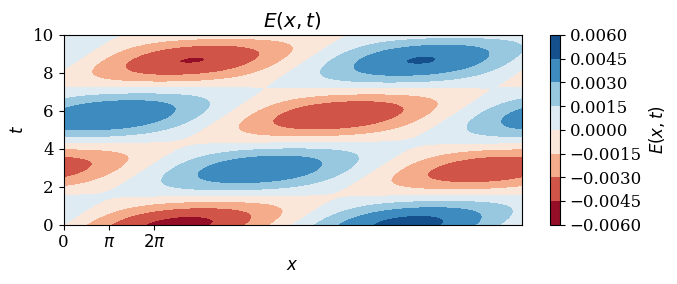

In [20]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, sol_midpoint_t, E_field.T, cmap="RdBu")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("figs/SW_sqrt/ion_acoustic/poisson/electric_field_SW_sqrt.png", dpi=600)

In [21]:
E1_midpoint = np.zeros(len(sol_midpoint_t))


for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(E_midpoint[Nx+1, ii])

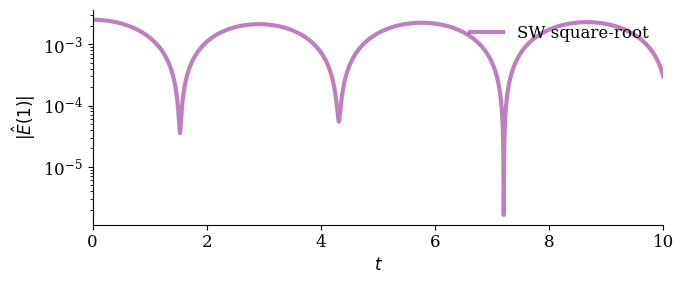

In [22]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "-", c="purple", alpha=0.5, linewidth=3, label="SW square-root") 
#ax.plot(sol_midpoint_t, np.exp(-0.851*sol_midpoint_t)*1e-2, linewidth=3, color="red", label=r"theory $\gamma = -0.851$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("figs/SW_sqrt/ion_acoustic/poisson/growth_rate_electric_field.png", dpi=600)

# Conservation Laws

# Mass conservation 

$$
N^{s}(t) = \alpha^{s} \sum_{n=0}^{N_{v}-1} \int_{0}^{L} C_{n}^{s}(x, t)^{2}\mathrm{d}x =  \alpha^{s} \sum_{n=0}^{N_{v}-1} \int_{0}^{L} \sum_{k=-N_{x}}^{N_{x}} \sum_{m=-N_{x}}^{N_{x}} C_{n, k}^{s}(t) C_{n, m}^{s}(t) \exp(2\pi x i k/ L) \exp(2\pi x i m/ L) \mathrm{d}x
$$


In [23]:
def integral(k, m):
    return -1j*L*(1+np.exp(2*np.pi*1j*(k+m)))/(2*(k+m)*np.pi)

In [24]:
def mass(state):
    y = 0
    for nn in range(0, Nv):
        for ii, kk in enumerate(range(-Nx, Nx+1)):
            y += L * np.abs(state[nn, ii])**2
    return y 

In [25]:
mass_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = mass(state_e_midpoint[:, :, ii])*alpha_e + mass(state_i_midpoint[:, :, ii])*alpha_i

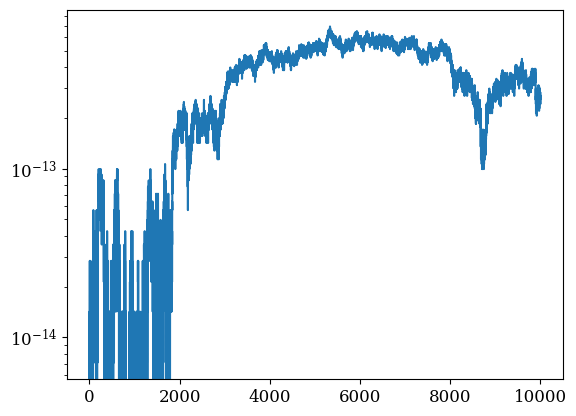

In [26]:
plt.plot(mass_midpoint.real - mass_midpoint.real[0])
plt.yscale("log")

In [27]:
def term2(state):
    res = 0
    for nn in range(1, Nv):
        for ii, kk in enumerate(range(-Nx, Nx+1)):
            res += L * np.sqrt(nn/2)* state[nn-1, Nx - kk] * state[nn, ii]
    return res

In [28]:
momentum_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = m_e*alpha_e*(u_e*mass(state_e_midpoint[:, :, ii]) + alpha_e*(2*term2(state_e_midpoint[:, :, ii])))\
                          + m_i*alpha_i*(u_i*mass(state_i_midpoint[:, :, ii]) + alpha_i*(2*term2(state_i_midpoint[:, :, ii])))

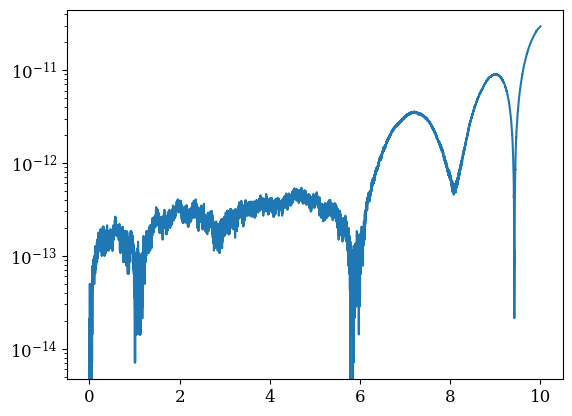

In [29]:
plt.plot(sol_midpoint_t, np.abs(momentum_midpoint.real - momentum_midpoint.real[0]))
plt.yscale("log")